# MSc Data Science: playing with binarised **MNIST**

In this tutorial, we'll play a bit with a binarised version of MNIST.

# Loading useful stuff

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and binarising it

In [0]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test =tf.cast(y_test, tf.int64)

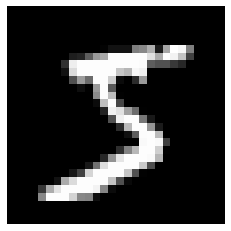

In [0]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

Then we binarise the data. There are many ways to do that. Here, we simply round the numbers, following the [TF tutorial on convolutional VAEs](https://www.tensorflow.org/tutorials/generative/cvae).

In [0]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

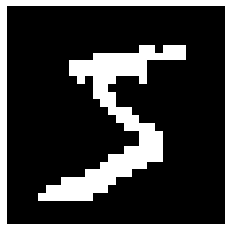

In [0]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

## Classification

Let us first build a small neural net to classify MNIST. The model is:
$$ p (y | \mathbf{x} ) = \text{Cat} (y |\text{Softmax}(\mathbf{W}_1\sigma(\mathbf{W}_0\mathbf{x}+\mathbf{b}_0)+\mathbf{b}_1)).$$

In [0]:
h = 200 # number of hidden units
sigma = "relu" # activation function

classifier = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(10), # because we have 10 classes
  tfkl.Softmax()
])

To train the classifier, we define a function that performs a gradient descent step. First, we choose the flavour of SGD that we want (in this case, Adam).

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

We can now define the gradient step:

In [0]:
@tf.function
def train_step(data, labels):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    preds = classifier(data)
    p_ygivenx_model = tfd.Categorical(probs = preds) # One could also use logits rather than probs and remove the softmax layer...
    logp_ygivenx = p_ygivenx_model.log_prob(labels)
    loss = -tf.reduce_mean(logp_ygivenx)  # the loss is the average negative log likelihood
  gradients = tape.gradient(loss, classifier.trainable_variables)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, classifier.trainable_variables))  # Adam iteration

To evaluate the quality of our model, we will write a function that computes both accuracy and log_likelihood. We don't care about gradients here bacause it's only for evaluation (not for training).

In [0]:
@tf.function
def evaluate(data, labels):
  preds = classifier(data)
  p_ygivenx_model = tfd.Categorical(probs = preds)
  logp_ygivenx = p_ygivenx_model.log_prob(labels)
  log_likelihood = tf.reduce_mean(logp_ygivenx)
  y_pred = tf.argmax(preds,1)
  acc = tf.reduce_mean(tf.cast(y_pred == labels,tf.float32))
  return acc, log_likelihood

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,y_train)).shuffle(60000).batch(32) # TF creates the batches for us

In [0]:
EPOCHS = 5

for epoch in range(1,EPOCHS+1):
  for images, labels in train_dataset:
    train_step(images, labels) # Adam iteration
  acc, log_likelihood = evaluate(train_images,y_train)
  acc_test, log_likelihood_test = evaluate(test_images,y_test)
  print('Epoch  %g' %epoch)
  print('Train accuracy  %g' %acc.numpy())
  print('Test accuracy  %g' %acc_test.numpy())
  print('Train log-likelihood  %g' %log_likelihood.numpy())
  print('Test log-likelihood  %g' %log_likelihood_test.numpy())
  print('-----------')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch  1
Train accuracy  0.911933
Test accuracy  0.9113
Train log-likelihood  -0.31469
Test log-likelihood  -0.308632
-----------
Epoch  2
Train accuracy  0.932317
Test accuracy  0.9309
Train log-likelihood  -0.242203
Test log-likelihood  -0.244548
-----------
Epoch  3
Train accuracy  0.94525
Test accuracy  0.9408
Train log-likelihood  -0.196561
Test log-likelihood  -0.205875
-----------
Epoch  4
Train accuracy  0.954
Test accuracy  0.9489
Train log-likelihood  -0.167545
Test log-likelihood  -0.17856
--

# Simple generative modelling

We build here a **super simple** generative model for the data set. Specifically, the model is simply a product of Bernoulli distributions:
$$p (\textbf{x}) = \prod_{j = 1}^p \mathcal{B}(x_j|\pi_j).$$

Why is this clearly a pretty bad model?

Training can simply be done by computing the means of all the pixels independently:

In [0]:
pis_bern = train_images.mean(0) + 10**(-10) # I just add 10^-10 to avoid zeros and numerical problems 

In [0]:
prod_of_bernoullis =  tfd.Independent(distribution  = tfd.Bernoulli(probs = pis_bern), reinterpreted_batch_ndims = 1)

In [0]:
prod_of_bernoullis = tfd.Independent(distribution  = tfd.Bernoulli(probs = pis_bern), reinterpreted_batch_ndims=1)

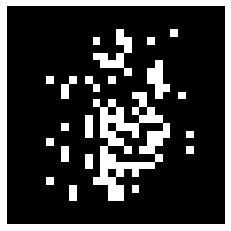

In [0]:
sample_pofbern = tf.reshape(prod_of_bernoullis.sample(1),(28,28))
plt.imshow(sample_pofbern, cmap='gray')
plt.axis('off')
plt.show()

We usually assess the quality of such generative models by computing the **test log-likelihood**. Here, we can do that easily because the model is simple:

In [0]:
tf.reduce_mean(prod_of_bernoullis.log_prob(test_images)).numpy()

-205.84973740976156

The state of the art for binarised versions of MNIST is around -75, which is much higher than that! Using a VAE (or an IWAE), try to close this gap!

# VAE

In [0]:
d = 10 # dimension of latent space

In [0]:
decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(28*28),  # I don't care (YET) about the fact that those are probabilities (in [0,1])
])

encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(2*d), # I don't care (YET) about the fact that half of these must be non-negative (diagonal of covariance)
])